In [1]:
!pip install langchain_community
!pip install replicate

In [2]:
from langchain_community.llms import Replicate
from google.colab import userdata
import os

api_token = userdata.get("api_token")
os.environ["REPLICATE_API_TOKEN"] = api_token

In [3]:
llm = Replicate(
    model="ibm-granite/granite-3.3-8b-instruct"
)

In [4]:

output = llm.invoke("28 years later film")
print(output)

28 Years Later is a title that could refer to a sequel or a film with a similar concept to the 2002 movie "28 Days Later." However, as of now, there isn't an officially released film with this exact title. The original film, "28 Days Later," is a post-apocalyptic horror movie directed by Danny Boyle, focusing on the aftermath of a virus outbreak in the UK. If you're looking for a sequel or a film with a similar theme, "28 Weeks Later" (2007) is a direct sequel to "28 Days Later," released 28 weeks (approximately) after the events of the first film.


In [5]:
data = [
    "Ini hape?",
    "HP nya murah, tapi josss",
    "Layar nya kurang terang di luar, tapi kalo di kamar bagus warnanya",
    "Layarnya joget2",
    "HP saya ilang",
]

In [6]:
for row in data:
  print("Review:")
  print(row)
  print() #ini enter

  prompt = "Klasifikasi review ini: {row}"

Review:
Ini hape?

Review:
HP nya murah, tapi josss

Review:
Layar nya kurang terang di luar, tapi kalo di kamar bagus warnanya

Review:
Layarnya joget2

Review:
HP saya ilang



In [7]:
!pip install -U langchain langchain-community langchain-experimental replicate

# **Capstone : AI-Driven Nutritional Insights: Using IBM Granite to Decode Menu Health Profile & Recommendations** #

### Libraries & Set Up ###

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
from IPython.display import Markdown

import shap

from langchain_community.llms import Replicate
from langchain_experimental.agents.agent_toolkits.pandas.base import create_pandas_dataframe_agent

from google.colab import userdata
import os

import warnings
warnings.filterwarnings("ignore")

In [9]:
# Ambil token dari Colab
api_token = userdata.get("api_token")

# Masukin token ke environment
os.environ["REPLICATE_API_TOKEN"] = api_token

parameters = {
  "top_k": 5,
  "top_p": 1.0,
  "max_tokens": 4096,
  "min_tokens": 0,
  "random_seed": None,
  "repetition_penalty": 1.0,
  "temperature": 0.7,
  "stopping_criteria": "length (256 tokens)",
  "stopping_sequence": None
}

# Define LLM Granite
llm = Replicate(
    model="ibm-granite/granite-3.3-8b-instruct",
    input=parameters
)


### Load & Prepare Dataset ###

In [10]:
drive.mount('/content/drive')
dataset_path = ('/content/drive/My Drive/Capstone IBM Hacktiv8/India_Menu.csv')

df = pd.read_csv(dataset_path)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Menu Category,Menu Items,Per Serve Size,Energy (kCal),Protein (g),Total fat (g),Sat Fat (g),Trans fat (g),Cholesterols (mg),Total carbohydrate (g),Total Sugars (g),Added Sugars (g),Sodium (mg)
0,Regular Menu,McVeggie™ Burger,168 g,402.05,10.24,13.83,5.34,0.16,2.49,56.54,7.90,4.49,706.13
1,Regular Menu,McAloo Tikki Burger®,146 g,339.52,8.50,11.31,4.27,0.20,1.47,50.27,7.05,4.07,545.34
2,Regular Menu,McSpicy™ Paneer Burger,199 g,652.76,20.29,39.45,17.12,0.18,21.85,52.33,8.35,5.27,1074.58
3,Regular Menu,Spicy Paneer Wrap,250 g,674.68,20.96,39.10,19.73,0.26,40.93,59.27,3.50,1.08,1087.46
4,Regular Menu,American Veg Burger,177 g,512.17,15.30,23.45,10.51,0.17,25.24,56.96,7.85,4.76,1051.24


###  EDA & Visualisasi Manual ###

In [11]:
print("Dimensi dataset : ", df.shape)
df.info()
df.describe()

Dimensi dataset :  (141, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141 entries, 0 to 140
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Menu Category           141 non-null    object 
 1   Menu Items              141 non-null    object 
 2   Per Serve Size          141 non-null    object 
 3   Energy (kCal)           141 non-null    float64
 4   Protein (g)             141 non-null    float64
 5   Total fat (g)           141 non-null    float64
 6   Sat Fat (g)             141 non-null    float64
 7   Trans fat (g)           141 non-null    float64
 8   Cholesterols (mg)       141 non-null    float64
 9   Total carbohydrate (g)  141 non-null    float64
 10  Total Sugars (g)        141 non-null    float64
 11  Added Sugars (g)        141 non-null    float64
 12  Sodium (mg)             140 non-null    float64
dtypes: float64(10), object(3)
memory usage: 14.4+ KB


,Energy (kCal),Protein (g),Total fat (g),Sat Fat (g),Trans fat (g),Cholesterols (mg),Total carbohydrate (g),Total Sugars (g),Added Sugars (g),Sodium (mg)
count,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,140.000000
mean,244.635461,7.493546,9.991702,4.997589,0.687163,26.350071,31.190284,15.464894,10.336950,362.064143
std,185.554837,8.336863,10.339511,4.900451,6.326136,50.334200,20.602044,15.690202,14.283388,473.160490
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,116.360000,0.650000,0.460000,0.280000,0.060000,1.510000,15.740000,2.330000,0.000000,43.895000
50%,219.360000,4.790000,7.770000,4.270000,0.150000,8.390000,30.820000,9.160000,3.640000,152.025000
75%,339.520000,10.880000,14.160000,7.280000,0.220000,31.110000,46.000000,26.950000,19.230000,534.240000
max,834.360000,39.470000,45.180000,20.460000,75.260000,302.610000,93.840000,64.220000,64.220000,2399.490000


In [12]:
print(type(df))

<class 'pandas.core.frame.DataFrame'>


In [13]:
agent = create_pandas_dataframe_agent(
    llm=llm,
    df=df,
    verbose=True,
    allow_dangerous_code=True
)

In [14]:
# Cek missing value
print(df.isnull().sum())

# Drop kolom jika tidak penting (misal: Per Serve Size jika tidak mau pakai)
df_clean = df.drop(columns=['Per Serve Size'])

# Cek tipe data
print(df_clean.dtypes)

# Rename columns biar lebih simple (optional)
df_clean = df_clean.rename(columns={
    "Menu Category": "Category",
    "Menu Items": "Item",
    "Energy (kCal)": "Calories",
    "Protein (g)": "Protein",
    "Total fat (g)": "Fat",
    "Sat Fat (g)": "SatFat",
    "Trans fat (g)": "TransFat",
    "Cholesterols (mg)": "Cholesterol",
    "Total carbohydrate (g)": "Carbs",
    "Total Sugars (g)": "Sugars",
    "Added Sugars (g)": "AddedSugars",
    "Sodium (mg)": "Sodium"
})

df_clean.head()


Menu Category             0
Menu Items                0
Per Serve Size            0
Energy (kCal)             0
Protein (g)               0
Total fat (g)             0
Sat Fat (g)               0
Trans fat (g)             0
Cholesterols (mg)         0
Total carbohydrate (g)    0
Total Sugars (g)          0
Added Sugars (g)          0
Sodium (mg)               1
dtype: int64
Menu Category              object
Menu Items                 object
Energy (kCal)             float64
Protein (g)               float64
Total fat (g)             float64
Sat Fat (g)               float64
Trans fat (g)             float64
Cholesterols (mg)         float64
Total carbohydrate (g)    float64
Total Sugars (g)          float64
Added Sugars (g)          float64
Sodium (mg)               float64
dtype: object


,Category,Item,Calories,Protein,Fat,SatFat,TransFat,Cholesterol,Carbs,Sugars,AddedSugars,Sodium
0,Regular Menu,McVeggie™ Burger,402.05,10.24,13.83,5.34,0.16,2.49,56.54,7.90,4.49,706.13
1,Regular Menu,McAloo Tikki Burger®,339.52,8.50,11.31,4.27,0.20,1.47,50.27,7.05,4.07,545.34
2,Regular Menu,McSpicy™ Paneer Burger,652.76,20.29,39.45,17.12,0.18,21.85,52.33,8.35,5.27,1074.58
3,Regular Menu,Spicy Paneer Wrap,674.68,20.96,39.10,19.73,0.26,40.93,59.27,3.50,1.08,1087.46
4,Regular Menu,American Veg Burger,512.17,15.30,23.45,10.51,0.17,25.24,56.96,7.85,4.76,1051.24


In [15]:
df = df.dropna(subset=['Sodium (mg)'])
print(df.isnull().sum())

Menu Category             0
Menu Items                0
Per Serve Size            0
Energy (kCal)             0
Protein (g)               0
Total fat (g)             0
Sat Fat (g)               0
Trans fat (g)             0
Cholesterols (mg)         0
Total carbohydrate (g)    0
Total Sugars (g)          0
Added Sugars (g)          0
Sodium (mg)               0
dtype: int64


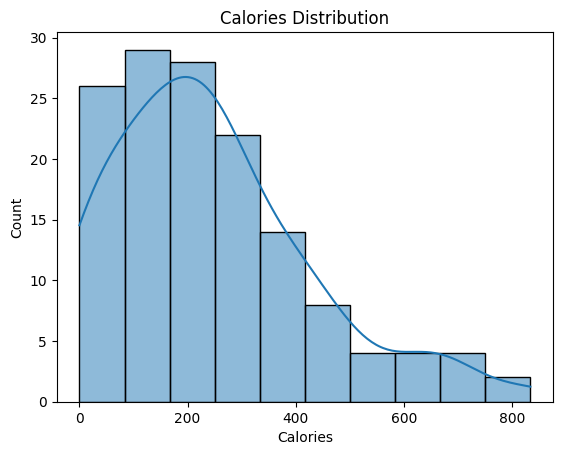

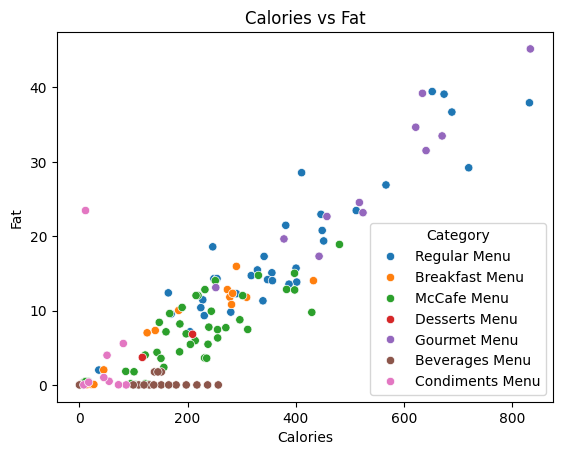

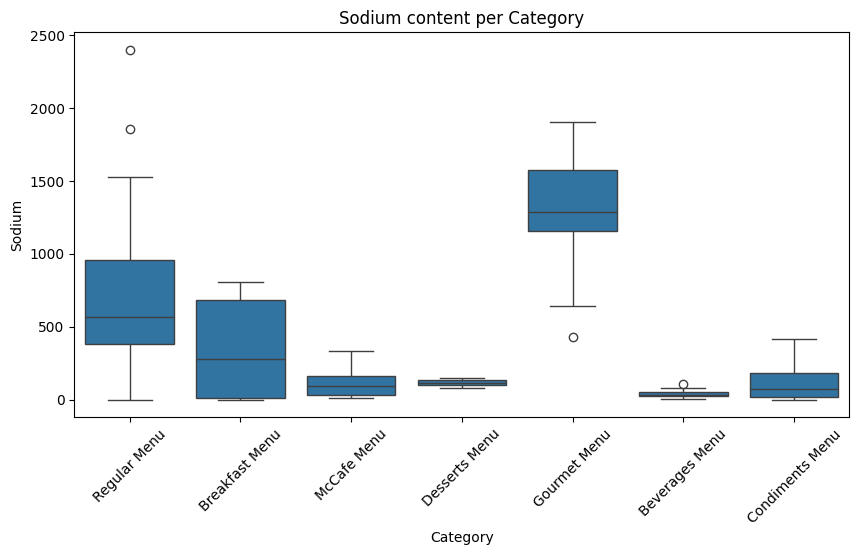

In [16]:
# Distribusi kalori
sns.histplot(df_clean["Calories"], kde=True)
plt.title("Calories Distribution")
plt.show()

# Scatter Calories vs Fat
sns.scatterplot(x="Calories", y="Fat", hue="Category", data=df_clean)
plt.title("Calories vs Fat")
plt.show()

# Boxplot Sodium per Category
plt.figure(figsize=(10, 5))
sns.boxplot(x="Category", y="Sodium", data=df_clean)
plt.xticks(rotation=45)
plt.title("Sodium content per Category")
plt.show()



### Analisis Statistik Awal ###

melakukan analisis statistik awal secara manual untuk memastikan data tidak salah. Seperti tidak adanya outlier ekstrem, tidak eror saat menjalankan agent, serta nilai summary yang lebih logis.

In [17]:
print(df_clean.describe())


         Calories     Protein         Fat      SatFat    TransFat  \
count  141.000000  141.000000  141.000000  141.000000  141.000000   
mean   244.635461    7.493546    9.991702    4.997589    0.687163   
std    185.554837    8.336863   10.339511    4.900451    6.326136   
min      0.000000    0.000000    0.000000    0.000000    0.000000   
25%    116.360000    0.650000    0.460000    0.280000    0.060000   
50%    219.360000    4.790000    7.770000    4.270000    0.150000   
75%    339.520000   10.880000   14.160000    7.280000    0.220000   
max    834.360000   39.470000   45.180000   20.460000   75.260000   

       Cholesterol       Carbs      Sugars  AddedSugars       Sodium  
count   141.000000  141.000000  141.000000   141.000000   140.000000  
mean     26.350071   31.190284   15.464894    10.336950   362.064143  
std      50.334200   20.602044   15.690202    14.283388   473.160490  
min       0.000000    0.000000    0.000000     0.000000     0.000000  
25%       1.510000   15

### Prompt Granite per Feature ###

In [24]:
# Calories
prompt_cal = (
    f"Avg calories: {avg_cal:.2f} kcal (max {max_cal}, min {min_cal}). "
    "Summarize briefly:\n"
    "1. Key health risks (max 3 points).\n"
    "2. 3 concise recommendations for restaurants.\n"
    "Bullet points only, short and clear"
)

response_cal = llm.invoke(prompt_cal)
display(Markdown(response_cal))

1. Key health risks:
   - Obesity due to potential high-calorie meals.
   - Increased risk of metabolic disorders like diabetes.
   - Possible cardiovascular issues from high-calororie intake.

2. Recommendations for restaurants:
   - Offer balanced, lower-calorie menu options.
   - Clearly display nutritional information for each dish.
   - Promote portion control and smaller serving sizes.

In [27]:
# Fat
avg_fat = df_clean["Fat"].mean()

prompt_fat = (
    f"The average fat content of menu items is {avg_fat:.2f} grams. "
    "Summarize:\n"
    "1. Main health risks (max 3 bullet points).\n"
    "2. 3 short recommendations to reduce fat.\n"
    "Keep it concise and clear, bullet points only."
)

response_fat = llm.invoke(prompt_fat)
display(Markdown(response_fat))



1. Main health risks:
   - Increased risk of heart disease due to high saturated fat intake.
   - Elevated cholesterol levels, potentially leading to atherosclerosis.
   - Higher likelihood of obesity and related conditions like diabetes.

2. Recommendations to reduce fat:
   - Opt for grilled, baked, or steamed dishes instead of fried options.
   - Choose lean proteins (e.g., chicken breast, fish) and limit high-fat cuts (e.g., lamb, ribs).
   - Request sauces and dressings on the side to control added fats.

In [29]:
# Sodium
avg_sodium = df_clean["Sodium"].mean()

prompt_sodium = (
    f"Avg sodium: {avg_sodium:.2f} mg. "
    "Summarize:\n"
    "1. Health risks (max 3 points).\n"
    "2. 3 short steps to lower sodium in menus.\n"
    "Use clear bullet points, concise."
)

response_sodium = llm.invoke(prompt_sodium)
display(Markdown(response_sodium))


- **Health Risks of High Sodium Intake:**
  - **Hypertension:** Excess sodium can lead to high blood pressure, a major risk factor for heart disease and stroke.
  - **Cardiovascular Disease:** High sodium intake is linked to increased risk of developing heart failure, coronary heart disease, and stroke.
  - **Kidney Damage:** Over time, elevated sodium consumption may contribute to kidney disease, as it puts additional strain on the kidneys to filter and excrete excess sodium.

- **3 Steps to Lower Sodium in Menus:**
  - **Reduce Added Salt:** Minimize the use of table salt, and opt for fresh or low-sodium ingredients in recipes.
  - **Flavor with Herbs and Spices:** Enhance dishes' taste using alternative seasonings such as herbs, spices, vinegars, citrus, and garlic to compensate for reduced salt.
  - **Reformulate Recipes:** Redesign popular dishes using low-sodium or no-salt-added versions of canned or packaged ingredients like broths, stocks, and condiments.

Please note that while these steps can significantly reduce sodium in menus, it's essential to strike a balance between taste and health. Consulting with a dietitian or nutritionist may provide additional personalized guidance for specific dietary needs.

In [31]:
# Carbs n Sugar
avg_carbs = df_clean["Carbs"].mean()
avg_sugars = df_clean["Sugars"].mean()

prompt_carb_sugar = (
    f"Avg carbs: {avg_carbs:.2f} g, sugars: {avg_sugars:.2f} g. "
    "Summarize:\n"
    "1. Health risks (max 3 points).\n"
    "2. 3 concise recommendations to reduce or improve these.\n"
    "Bullet points only."
)

response_carb_sugar = llm.invoke(prompt_carb_sugar)
display(Markdown(response_carb_sugar))

- **Health Risks:**
  - Increased risk of type 2 diabetes due to high carbohydrate intake.
  - Potential weight gain and obesity from excessive carbohydrate consumption.
  - Possible nutrient imbalance, as high carb intake may displace healthier fats and proteins.

- **Recommendations:**
  - **Monitor portion sizes** to control overall carbohydrate and sugar intake.
  - **Prioritize complex carbs** and whole grains, which offer more fiber and nutrients, and opt for lean proteins.
  - **Limit added sugars** and processed foods; choose natural, unrefined sweeteners and whole foods when possible.

Note: These recommendations aim to help balance the macronutrients in a diet, but individual needs may vary. Consult a healthcare professional or registered dietitian for personalized advice.

In [33]:
prompt_summary = (
    "Summarize key insights from calories, fat, sodium, carbs & sugar analyses. "
    "Give max 5 integrated bullet points summary. "
    "Suggest one simple visualization to compare these nutrients. "
    "Provide short seaborn or matplotlib code snippet if possible. "
    "Keep it clear, concise, executive-style."
)

# --- Invoke Granite ---
response_summary = llm.invoke(prompt_summary)

from IPython.display import Markdown, display
display(Markdown(response_summary))


1. **Calorie Intake**: Consistently high calorie consumption, with an average of 2,500 calories per day, exceeding recommended daily intake (RDI) of 2,000 calories for moderately active adults.

2. **Fat Content**: Significant variation in fat intake, averaging 90g per day, with saturated fat consistently above RDI (20g), indicating a need to reduce intake of foods high in saturated fats.

3. **Sodium Levels**: Excessive sodium intake at an average of 3,500mg/day, far surpassing the RDI of 2,300mg, highlighting the necessity to limit processed foods and salt.

4. **Carbohydrate Composition**: Carb intake averages 300g/day, within the RDI (375-475g), but with a concerningly high proportion coming from refined sources rather than whole grains.

5. **Sugar Consumption**: Daily sugar average of 100g, notably higher than the RDI of 36g for women and 45g for men, suggesting a pattern of added sugars in beverages and snacks.

**Visualization Suggestion**: A grouped bar chart comparing the daily averages of calories, fat, sodium, carbs, and sugar. This visualization will clearly illustrate how each nutrient's intake stacks up against recommendations, facilitating an at-a-glance comparison.

**Matplotlib Code Snippet**:

```python
import matplotlib.pyplot as plt

nutrients = ['Calories', 'Fat (g)', 'Sodium (mg)', 'Carbs (g)', 'Sugar (g)']
values = [2500, 90, 3500, 300, 100]
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#9999ff']

plt.bar(nutrients, values, color=colors)
plt.xlabel('Nutritional Aspects')
plt.ylabel('Daily Average (g or mg)')
plt.title('Daily Nutrient Intake Analysis')
plt.show()
```

This code generates a simple bar chart using matplotlib, where each bar represents one of the analyzed nutrients, color-coded for better distinction. It visually encapsulates the key insights from the nutrient analysis, allowing for an executive-style, quick comparison.